# Assignment 1
Authors: Kamil Kojs, János Máté and Jorge del Pozo Lérida

CHECKLIST: Overall

* [ ] Assignment: Concise discussion of the results
* [ ] Plots: Labels and titles clear and readable?
* [ ] Code: can run the whole notebook? Modular, concise, and documented
code?

### Dataset
US Census data from https://github.com/zykls/folktables. 

We use data of individuals from the state California in 2018. 
More details on the dataset can be found in the accompanying
paper at https://arxiv.org/pdf/2108.04884.pdf.

In [1]:
from folktables.acs import adult_filter
from folktables import ACSDataSource
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
pd.set_option('display.max_columns', None)


data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["CA"], download=True)

feature_names = ['AGEP', # Age
                 "CIT", # Citizenship status
                 'COW', # Class of worker
                 "ENG", # Ability to speak English
                 'SCHL', # Educational attainment
                 'MAR', # Marital status
                 "HINS1", # Insurance through a current or former employer or union
                 "HINS2", # Insurance purchased directly from an insurance company
                 "HINS4", # Medicaid
                 "RAC1P", # Recoded detailed race code
                 'SEX']

target_name = "PINCP" # Total person's income

def data_processing(data, features, target_name:str, threshold: float = 35000):
    df = data
    ### Adult Filter (STARTS) (from Foltktables)
    df = df[~df["SEX"].isnull()]
    df = df[~df["RAC1P"].isnull()]
    df = df[df['AGEP'] > 16]
    df = df[df['PINCP'] > 100]
    df = df[df['WKHP'] > 0]
    df = df[df['PWGTP'] >= 1]
    ### Adult Filter (ENDS)
    ### Groups of interest
    sex = df["SEX"].values
    ### Target
    df["target"] = df[target_name] > threshold
    target = df["target"].values
    df = df[features + ["target", target_name]] ##we want to keep df before one_hot encoding to make Bias Analysis
    df_processed = df[features].copy()
    cols = [ "HINS1", "HINS2", "HINS4", "CIT", "COW", "SCHL", "MAR", "SEX", "RAC1P"]
    df_processed = pd.get_dummies(df_processed, prefix=None, prefix_sep='_', dummy_na=False, columns=cols, drop_first=True)
    df_processed = pd.get_dummies(df_processed, prefix=None, prefix_sep='_', dummy_na=True, columns=["ENG"], drop_first=True)
    return df_processed, df, target, sex

## Task1: Classifiers and fairness considerations

CHECKLIST: Task 1
* [ ] Part 1: Discussion feature engineering and scaling steps
* [ ] Part 1: Correct implementation of one-hot-encoding (if used for model)
* [ ] Part 1: Build and train relevant models
* [ ] Part 2: Code of statistical parity, equalized odds and equalized outcome
* [ ] Part 2: Plot comparing the three metrics
* [ ] Part 3: Discussion on accuracy changes and how other measures were
affected by the intervention?

In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import shap
import plotly.express as px
import pandas as pd
import random
import matplotlib.pyplot as plt

mm_scaler = MinMaxScaler()

In [3]:
data, data_original, target, group = data_processing(acs_data, feature_names, target_name)
data

,AGEP,HINS1_2,HINS2_2,HINS4_2,CIT_2,CIT_3,CIT_4,CIT_5,COW_2.0,COW_3.0,COW_4.0,COW_5.0,COW_6.0,COW_7.0,COW_8.0,SCHL_2.0,SCHL_3.0,SCHL_4.0,SCHL_5.0,SCHL_6.0,SCHL_7.0,SCHL_8.0,SCHL_9.0,SCHL_10.0,SCHL_11.0,SCHL_12.0,SCHL_13.0,SCHL_14.0,SCHL_15.0,SCHL_16.0,SCHL_17.0,SCHL_18.0,SCHL_19.0,SCHL_20.0,SCHL_21.0,SCHL_22.0,SCHL_23.0,SCHL_24.0,MAR_2,MAR_3,MAR_4,MAR_5,SEX_2,RAC1P_2,RAC1P_3,RAC1P_4,RAC1P_5,RAC1P_6,RAC1P_7,RAC1P_8,RAC1P_9,ENG_2.0,ENG_3.0,ENG_4.0,ENG_nan
0,30,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
6,21,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
7,65,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
10,33,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13,18,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378801,38,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
378802,39,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
378807,61,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
378811,69,1,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0


In [4]:
data["AGEP"] = mm_scaler.fit_transform(np.array(data["AGEP"]).reshape(-1,1))
data

,AGEP,HINS1_2,HINS2_2,HINS4_2,CIT_2,CIT_3,CIT_4,CIT_5,COW_2.0,COW_3.0,COW_4.0,COW_5.0,COW_6.0,COW_7.0,COW_8.0,SCHL_2.0,SCHL_3.0,SCHL_4.0,SCHL_5.0,SCHL_6.0,SCHL_7.0,SCHL_8.0,SCHL_9.0,SCHL_10.0,SCHL_11.0,SCHL_12.0,SCHL_13.0,SCHL_14.0,SCHL_15.0,SCHL_16.0,SCHL_17.0,SCHL_18.0,SCHL_19.0,SCHL_20.0,SCHL_21.0,SCHL_22.0,SCHL_23.0,SCHL_24.0,MAR_2,MAR_3,MAR_4,MAR_5,SEX_2,RAC1P_2,RAC1P_3,RAC1P_4,RAC1P_5,RAC1P_6,RAC1P_7,RAC1P_8,RAC1P_9,ENG_2.0,ENG_3.0,ENG_4.0,ENG_nan
0,0.168831,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
6,0.051948,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
7,0.623377,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
10,0.207792,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13,0.012987,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378801,0.272727,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
378802,0.285714,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
378807,0.571429,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
378811,0.675325,1,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0


In [5]:
data.describe()

,AGEP,HINS1_2,HINS2_2,HINS4_2,CIT_2,CIT_3,CIT_4,CIT_5,COW_2.0,COW_3.0,COW_4.0,COW_5.0,COW_6.0,COW_7.0,COW_8.0,SCHL_2.0,SCHL_3.0,SCHL_4.0,SCHL_5.0,SCHL_6.0,SCHL_7.0,SCHL_8.0,SCHL_9.0,SCHL_10.0,SCHL_11.0,SCHL_12.0,SCHL_13.0,SCHL_14.0,SCHL_15.0,SCHL_16.0,SCHL_17.0,SCHL_18.0,SCHL_19.0,SCHL_20.0,SCHL_21.0,SCHL_22.0,SCHL_23.0,SCHL_24.0,MAR_2,MAR_3,MAR_4,MAR_5,SEX_2,RAC1P_2,RAC1P_3,RAC1P_4,RAC1P_5,RAC1P_6,RAC1P_7,RAC1P_8,RAC1P_9,ENG_2.0,ENG_3.0,ENG_4.0,ENG_nan
count,195665.000000,195665.000000,195665.000000,195665.000000,195665.000000,195665.000000,195665.000000,195665.000000,195665.000000,195665.000000,195665.000000,195665.000000,195665.000000,195665.000000,195665.000000,195665.000000,195665.000000,195665.000000,195665.000000,195665.000000,195665.000000,195665.000000,195665.000000,195665.000000,195665.000000,195665.000000,195665.000000,195665.000000,195665.000000,195665.000000,195665.000000,195665.000000,195665.000000,195665.000000,195665.000000,195665.000000,195665.000000,195665.000000,195665.000000,195665.000000,195665.000000,195665.000000,195665.000000,195665.000000,195665.000000,195665.000000,195665.000000,195665.000000,195665.000000,195665.000000,195665.000000,195665.000000,195665.000000,195665.000000,195665.000000
mean,0.334220,0.348913,0.865377,0.856689,0.002009,0.012981,0.177078,0.135262,0.070600,0.080571,0.042419,0.025840,0.085192,0.039241,0.002903,0.000302,0.000296,0.000547,0.001359,0.003005,0.001998,0.002663,0.016656,0.002387,0.006164,0.011417,0.008382,0.016038,0.023300,0.168129,0.021210,0.066256,0.165390,0.080255,0.237784,0.100135,0.028799,0.019906,0.016830,0.090941,0.019053,0.349618,0.472001,0.043733,0.006613,0.000066,0.002300,0.167168,0.003256,0.116490,0.041939,0.087231,0.056183,0.019227,0.577916
std,0.193307,0.476628,0.341321,0.350391,0.044772,0.113194,0.381736,0.342004,0.256157,0.272176,0.201545,0.158658,0.279167,0.194167,0.053801,0.017362,0.017214,0.023379,0.036846,0.054737,0.044658,0.051533,0.127979,0.048796,0.078266,0.106241,0.091167,0.125620,0.150855,0.373982,0.144083,0.248730,0.371533,0.271688,0.425727,0.300181,0.167242,0.139679,0.128634,0.287526,0.136712,0.476851,0.499217,0.204501,0.081053,0.008151,0.047902,0.373127,0.056965,0.320812,0.200450,0.282174,0.230275,0.137321,0.493893
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.168831,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.324675,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.493506,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000

In [6]:
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    data, target, group, test_size=0.2, random_state=0)

X_test_male = X_test[group_test == 2]
X_test_female = X_test[group_test == 1]

y_test_male = y_test[group_test == 2]
y_test_female = y_test[group_test == 1]

### Black-box model

In [7]:
from sklearn.ensemble import RandomForestClassifier

# RandomForest
rf_model = RandomForestClassifier(n_estimators = 15, min_samples_split=0.03, min_samples_leaf=0.03, max_features="auto",
max_depth=15, criterion="gini", random_state=0)
rf_model.fit(X_train, y_train)

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


RandomForestClassifier(max_depth=15, max_features='auto', min_samples_leaf=0.03,
                       min_samples_split=0.03, n_estimators=15, random_state=0)

In [8]:
y_pred_rf = rf_model.predict(X_test)
print("accuracy:", accuracy_score(y_test, y_pred_rf))

y_pred_rf_male = rf_model.predict(X_test_male)
y_pred_rf_female = rf_model.predict(X_test_female)

print("accuracy male:", accuracy_score(y_test_male, y_pred_rf_male))
print("accuracy female:", accuracy_score(y_test_female, y_pred_rf_female))

accuracy: 0.7582602918253136
accuracy male: 0.7315795159896283
accuracy female: 0.7822123078415207


### White-box model

In [9]:
from sklearn.linear_model import LogisticRegression

# LogisticRegression
logreg_model = LogisticRegression(max_iter=5000, random_state=16, penalty="l2", tol=1e-4, solver="saga")
logreg_model.fit(X_train, y_train)

LogisticRegression(max_iter=5000, random_state=16, solver='saga')

In [10]:
y_pred_logreg = logreg_model.predict(X_test)
print("accuracy:", accuracy_score(y_test, y_pred_logreg))

y_pred_logreg_male = logreg_model.predict(X_test_male)
y_pred_logreg_female = logreg_model.predict(X_test_female)

print("accuracy male:", accuracy_score(y_test_male, y_pred_logreg_male))
print("accuracy female:", accuracy_score(y_test_female, y_pred_logreg_female))

accuracy: 0.7696573224644162
accuracy male: 0.7507562662057045
accuracy female: 0.786625284903739


### Fairness metrics

In [11]:
def get_fairnessmetrics(model):
    y_pred = model.predict(X_test)
    df = pd.DataFrame({"group": group_test, "pred": y_pred, "target": y_test})
    
    ### statistical parity
    female_sp = len(df.loc[(df["group"] == 1) & (df["pred"] == True)]) / len(df.loc[(df["group"] == 1)])
    male_sp = len(df.loc[(df["group"] == 2) & (df["pred"] == True)]) / len(df.loc[(df["group"] == 2)])
    # check if statistical parity is satisfied
    sp_list = [female_sp, male_sp]
    sp = (min(sp_list) / max(sp_list)) >= 0.8

    ### equalzed odds
    # true positive rate
    female_eo_tp = len(df.loc[(df["group"] == 1) & (df["pred"] == True) & (df["target"] == True)]) / len(df.loc[(df["group"] == 1) & (df["target"] == True)])
    male_eo_tp = len(df.loc[(df["group"] == 2) & (df["pred"] == True) & (df["target"] == True)]) / len(df.loc[(df["group"] == 2) & (df["target"] == True)])

    # false positive rate
    female_eo_fp = len(df.loc[(df["group"] == 1) & (df["pred"] == True) & (df["target"] == False)]) / len(df.loc[(df["group"] == 1) & (df["target"] == False)])
    male_eo_fp = len(df.loc[(df["group"] == 2) & (df["pred"] == True) & (df["target"] == False)]) / len(df.loc[(df["group"] == 2) & (df["target"] == False)])

    # check if equalized odds are satisfied
    eo_tp_list = [female_eo_tp, male_eo_tp]
    eo_tp = (min(eo_tp_list) / max(eo_tp_list)) >= 0.8

    eo_fp_list = [female_eo_fp, male_eo_fp]
    eo_fp = (min(eo_fp_list) / max(eo_fp_list)) >= 0.8

    eo = eo_tp and eo_fp

    ### equalized outcomes
    # true positive rate
    female_eoc_tp = len(df.loc[(df["group"] == 1) & (df["pred"] == True) & (df["target"] == True)]) / len(df.loc[(df["group"] == 1) & (df["pred"] == True)])
    male_eoc_tp = len(df.loc[(df["group"] == 2) & (df["pred"] == True) & (df["target"] == True)]) / len(df.loc[(df["group"] == 2) & (df["pred"] == True)])

    # false positive rate
    female_eoc_fp = len(df.loc[(df["group"] == 1) & (df["pred"] == False) & (df["target"] == True)]) / len(df.loc[(df["group"] == 1) & (df["pred"] == False)])
    male_eoc_fp = len(df.loc[(df["group"] == 2) & (df["pred"] == False) & (df["target"] == True)]) / len(df.loc[(df["group"] == 2) & (df["pred"] == False)])

    # check if equalized outcomes are satisfied
    eoc_tp_list = [female_eoc_tp, male_eoc_tp]
    eoc_tp = (min(eoc_tp_list) / max(eoc_tp_list)) >= 0.8

    eoc_fp_list = [female_eoc_fp, male_eoc_fp]
    eoc_fp = (min(eoc_fp_list) / max(eoc_fp_list)) >= 0.8

    eoc = eoc_tp and eoc_fp

    return sp, eo, eoc, sp_list, eo_tp_list, eo_fp_list, eoc_tp_list, eoc_fp_list

def plot_fairnessmetrics(model):
    # Code for plotting results of fairness data
    sp, eo, eoc, sp_list, eo_tp_list, eo_fp_list, eoc_tp_list, eoc_fp_list = get_fairnessmetrics(model)
    x_axis = np.array(["sp_female", "sp_male", "eo_tp_female", "eo_tp_male", "eo_fp_female", "eo_fp_male", "eoc_tp_female", "eoc_tp_male", "eoc_fp_female", "eoc_fp_male"])
    y_axis = np.array([sp_list[0], sp_list[1], eo_tp_list[0], eo_tp_list[1], eo_fp_list[0], eo_fp_list[1], eoc_tp_list[0], eoc_tp_list[1], eoc_fp_list[0], eoc_fp_list[1]])
    fig = px.bar(x=x_axis, y=y_axis, title="Fairness metrics", labels = {'x':"Fairness metric<br><sup>sp-statistical parity, eo-equalzed odds, eoc-equalized outcomes, tp-true positive, fp-false positive</sup>", 
              'y':'value'})
    fig.show()

    print(f"Is statistical parity satisfied: {sp}")
    print(f"Is equalzed odds satisfied: {eo}")
    print(f"Is equalized outcomes satisfied: {eoc}")

In [12]:
plot_fairnessmetrics(logreg_model)

Is statistical parity satisfied: True
Is equalzed odds satisfied: True
Is equalized outcomes satisfied: True


In [13]:
plot_fairnessmetrics(rf_model)

Is statistical parity satisfied: True
Is equalzed odds satisfied: True
Is equalized outcomes satisfied: False


### Equalized odds intervention

### white-box model

In [14]:
male_df = pd.DataFrame(columns=["thr", "fpr", "tpr"])
female_df = pd.DataFrame(columns=["thr", "fpr", "tpr"])

for threshold in reversed(range(0, 100)):
    y_pred = (logreg_model.predict_proba(X_test)[:,1] >= ((threshold+1)/100)).astype(bool)
    df = pd.DataFrame({"group": group_test, "pred": y_pred, "target": y_test})

    # postprocessing -> worsen male group, flip male predictions for 1% of the data because the lines dont intersect
    #for index, row in df.iterrows():
    #    if random.randint(0,100) < 1:
    #        if row["group"] == 2:
    #            df.at[index,'pred'] = not row["pred"]


    male_tpr = len(df.loc[(df["group"] == 2) & (df["pred"] == True) & (df["target"] == True)]) / len(df.loc[(df["group"] == 2) & (df["target"] == True)])
    male_fpr = len(df.loc[(df["group"] == 2) & (df["pred"] == True) & (df["target"] == False)]) / len(df.loc[(df["group"] == 2) & (df["target"] == False)])
    male_df = male_df.append(pd.DataFrame({"thr": [threshold], "fpr": [male_fpr], "tpr": [male_tpr]}), ignore_index=True)

    female_tpr = len(df.loc[(df["group"] == 1) & (df["pred"] == True) & (df["target"] == True)]) / len(df.loc[(df["group"] == 1) & (df["target"] == True)])
    female_fpr = len(df.loc[(df["group"] == 1) & (df["pred"] == True) & (df["target"] == False)]) / len(df.loc[(df["group"] == 1) & (df["target"] == False)])
    female_df = female_df.append(pd.DataFrame({"thr": [threshold], "fpr": [female_fpr], "tpr": [female_tpr]}), ignore_index=True)

male_df["group"] = "male"
female_df["group"] = "female"

all_df = male_df.append(female_df)

/tmp/ipykernel_13262/3910771040.py:17: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_13262/3910771040.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_13262/3910771040.py:17: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_13262/3910771040.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_13262/3910771040.py:17: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_13262/3910771040.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a 

In [15]:
fig = px.line(all_df, x='fpr', y='tpr', color='group', title="ROC")
thresholds = all_df['thr'].tolist()
fig.update_traces(hovertemplate=thresholds)
fig.show()

In [16]:
print("thr 0.28 male, 0.37 female")
y_pred_male = (logreg_model.predict_proba(X_test_male)[:,1] >= 0.28).astype(bool)
y_pred_female = (logreg_model.predict_proba(X_test_female)[:,1] >= 0.37).astype(bool)
print("accuracy after intervention:", accuracy_score(np.concatenate([y_test_male,y_test_female]), np.concatenate([y_pred_male,y_pred_female])))

y_pred_logreg = logreg_model.predict(X_test)
print("accuracy before intervention:", accuracy_score(y_test, y_pred_logreg))

thr 0.28 male, 0.37 female
accuracy after intervention: 0.7407047760202387
accuracy before intervention: 0.7696573224644162


### black-box model

In [17]:
male_df = pd.DataFrame(columns=["thr", "fpr", "tpr"])
female_df = pd.DataFrame(columns=["thr", "fpr", "tpr"])

for threshold in reversed(range(0, 100)):
    y_pred = (rf_model.predict_proba(X_test)[:,1] >= ((threshold+1)/100)).astype(bool)
    df = pd.DataFrame({"group": group_test, "pred": y_pred, "target": y_test})

    # postprocessing -> worsen male group, flip male predictions for 2% of the data because the lines dont intersect
    for index, row in df.iterrows():
        if random.randint(0,100) < 1:
            if row["group"] == 1:
                df.at[index,'pred'] = not row["pred"]


    male_tpr = len(df.loc[(df["group"] == 2) & (df["pred"] == True) & (df["target"] == True)]) / len(df.loc[(df["group"] == 2) & (df["target"] == True)])
    male_fpr = len(df.loc[(df["group"] == 2) & (df["pred"] == True) & (df["target"] == False)]) / len(df.loc[(df["group"] == 2) & (df["target"] == False)])
    male_df = male_df.append(pd.DataFrame({"thr": [threshold], "fpr": [male_fpr], "tpr": [male_tpr]}), ignore_index=True)

    female_tpr = len(df.loc[(df["group"] == 1) & (df["pred"] == True) & (df["target"] == True)]) / len(df.loc[(df["group"] == 1) & (df["target"] == True)])
    female_fpr = len(df.loc[(df["group"] == 1) & (df["pred"] == True) & (df["target"] == False)]) / len(df.loc[(df["group"] == 1) & (df["target"] == False)])
    female_df = female_df.append(pd.DataFrame({"thr": [threshold], "fpr": [female_fpr], "tpr": [female_tpr]}), ignore_index=True)

male_df["group"] = "male"
female_df["group"] = "female"

all_df = male_df.append(female_df)

/tmp/ipykernel_13262/3695842546.py:17: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_13262/3695842546.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_13262/3695842546.py:17: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_13262/3695842546.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_13262/3695842546.py:17: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_13262/3695842546.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a 

In [18]:
fig = px.line(all_df, x='fpr', y='tpr', color='group', title="ROC")
thresholds = all_df['thr'].tolist()
fig.update_traces(hovertemplate=thresholds)
fig.show()

In [19]:
print("thr 0.72 male, 0.71 female")
y_pred_male = (rf_model.predict_proba(X_test_male)[:,1] >= 0.72).astype(bool)
y_pred_female = (rf_model.predict_proba(X_test_female)[:,1] >= 0.71).astype(bool)
print("accuracy after intervention:", accuracy_score(np.concatenate([y_test_male,y_test_female]), np.concatenate([y_pred_male,y_pred_female])))

y_pred_rf = rf_model.predict(X_test)
print("accuracy before intervention:", accuracy_score(y_test, y_pred_rf))

print("thr 0.44 male, 0.42 female")
y_pred_male = (rf_model.predict_proba(X_test_male)[:,1] >= 0.44).astype(bool)
y_pred_female = (rf_model.predict_proba(X_test_female)[:,1] >= 0.42).astype(bool)
print("accuracy after intervention:", accuracy_score(np.concatenate([y_test_male,y_test_female]), np.concatenate([y_pred_male,y_pred_female])))

y_pred_rf = rf_model.predict(X_test)
print("accuracy before intervention:", accuracy_score(y_test, y_pred_rf))

thr 0.72 male, 0.71 female
accuracy after intervention: 0.5443998671198221
accuracy before intervention: 0.7582602918253136
thr 0.44 male, 0.42 female
accuracy after intervention: 0.7242225231901465
accuracy before intervention: 0.7582602918253136


# Task2: Explaining white-box models

CHECKLIST: Task 2

* [ ] Part 1: Discussion on which features affect the negatively / positively.
Does it follow intuition?
* [ ] Part 2: Discussion on counterfactual

$logistic(\eta) = \frac{1}{1+exp(-\eta)}$

In [20]:
#X_train, X_test, y_train, y_test, group_train, group_test

'''
Theory recap:

- Linear Regression not good for classification: 
does not output probabilities but rather numbers + extrapolates values out of range
+ there is no meaningful threshold at which you can distinguish one class from the other
+ not able to multiclass classification

Solution:  logistic regression

Instead of fitting a straight line or hyper-
plane, the logistic regression model uses the logistic function to squeeze the output of a linear
equation between 0 and 1.

INTERPRETATION of Logistic Regresison:

The interpretation of the weights in logistic regression differs from the interpretation 
of the weights in linear regression, since the outcome in logistic regression is 
a probability between 0 and 1. The weights do not influence the probability linearly any longer. 


Logistic regression model is a linear model for the log odds,
("odds” probability of event divided by probability of no event; when wrapped in the logarithm it is called log odds)

-Numerical feature: If you increase the value of feature xj   by one unit, the estimated odds change by a factor of  
exp(βj)
 
-Binary categorical feature: One of the two values of the feature is the reference category (in some languages, the one encoded in 0). Changing the feature  
xj  from the reference category to the other category changes the estimated odds by a factor of  
exp(βj) .

'''

#print(X_test.shape)


# 
#print(logreg_model.coef_, logreg_model.intercept_)


'\nTheory recap:\n\n- Linear Regression not good for classification: \ndoes not output probabilities but rather numbers + extrapolates values out of range\n+ there is no meaningful threshold at which you can distinguish one class from the other\n+ not able to multiclass classification\n\nSolution:  logistic regression\n\nInstead of fitting a straight line or hyper-\nplane, the logistic regression model uses the logistic function to squeeze the output of a linear\nequation between 0 and 1.\n\nINTERPRETATION of Logistic Regresison:\n\nThe interpretation of the weights in logistic regression differs from the interpretation \nof the weights in linear regression, since the outcome in logistic regression is \na probability between 0 and 1. The weights do not influence the probability linearly any longer. \n\n\nLogistic regression model is a linear model for the log odds,\n("odds” probability of event divided by probability of no event; when wrapped in the logarithm it is called log odds)\n\n

$\frac{odds_{x_j+1}}{odds{x_j}}=exp\left(\beta_{j}(x_{j}+1)-\beta_{j}x_{j}\right)=exp\left(\beta_j\right)$

# Task3: Model-agnostic explanations

CHECKLIST: Task 3
* [ ] Part 1: Plot the shap plot (and force plot if applicable). Make sure that
you have plotted the correct values.
* [ ] Part 1: Is shap aggregated per feature?
* [ ] Part 2: Comparison to white-box model explanation from task 2
included?

### Logistic regression

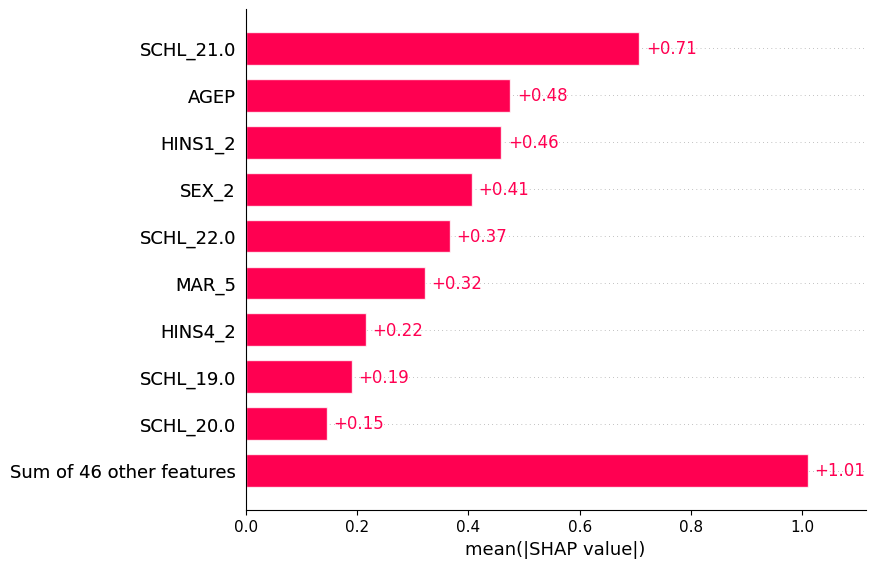

In [21]:
import shap
explainer_lr = shap.Explainer(logreg_model, X_train, feature_names=np.array(data.columns))
shap_values_lr = explainer_lr(X_test)
shap.plots.bar(shap_values_lr)

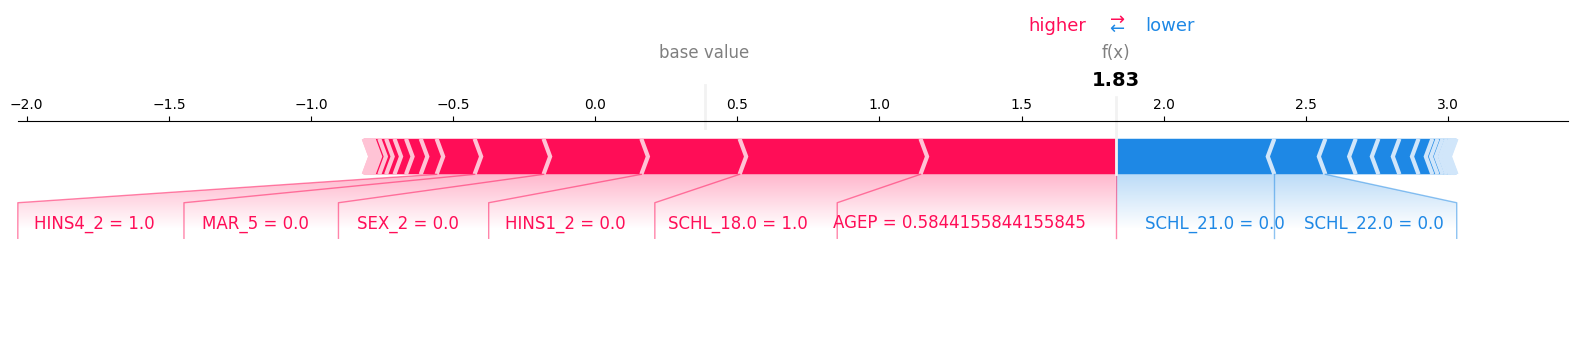

In [22]:
shap.force_plot(shap_values_lr[0],  matplotlib=True)

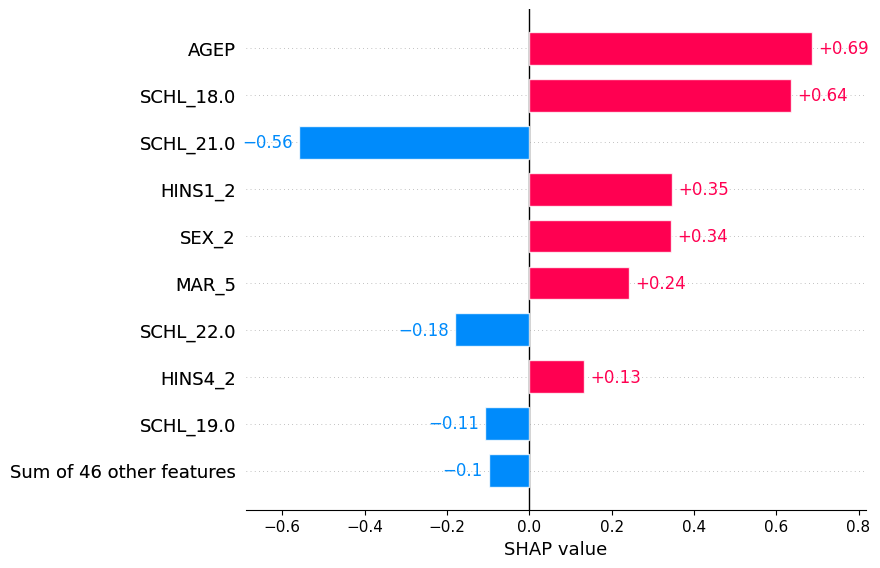

In [23]:
shap.plots.bar(shap_values_lr[0])

### Random Forest

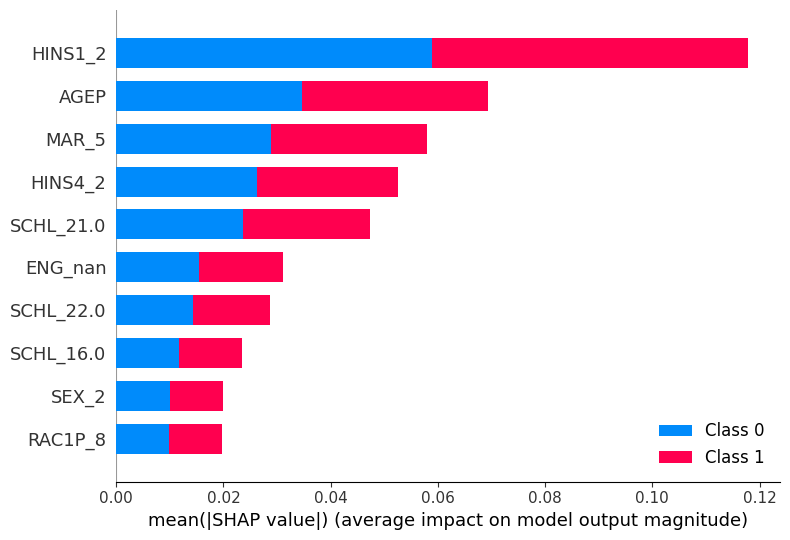

In [24]:
explainer_rf = shap.TreeExplainer(rf_model)
shap_values_rf = explainer_rf.shap_values(X_test)
shap.summary_plot(shap_values_rf, X_test, feature_names=data.columns, max_display = 10)

/home/janos/Documents/ITU/II_semester/venv/lib/python3.10/site-packages/shap/plots/_beeswarm.py:664: UserWarning:

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored



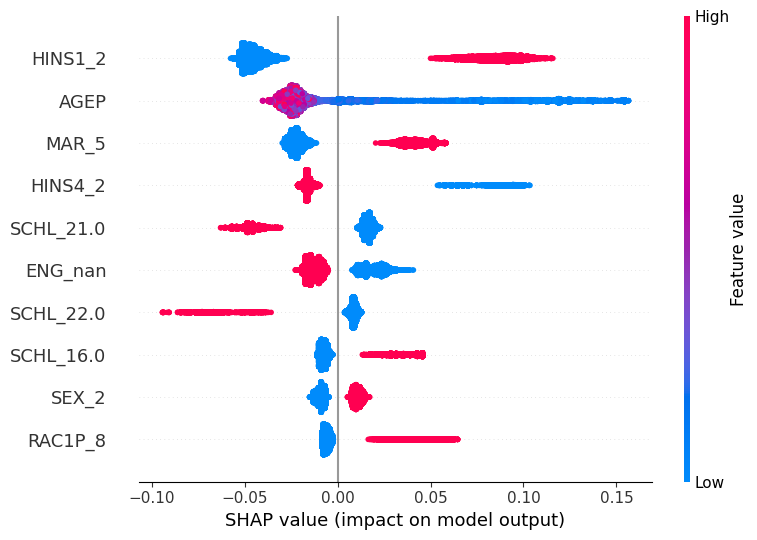

In [25]:
explainer_rf = shap.TreeExplainer(rf_model)
shap_values_rf = explainer_rf.shap_values(X_test)
shap.summary_plot(shap_values_rf[0], X_test, feature_names=data.columns, max_display = 10)

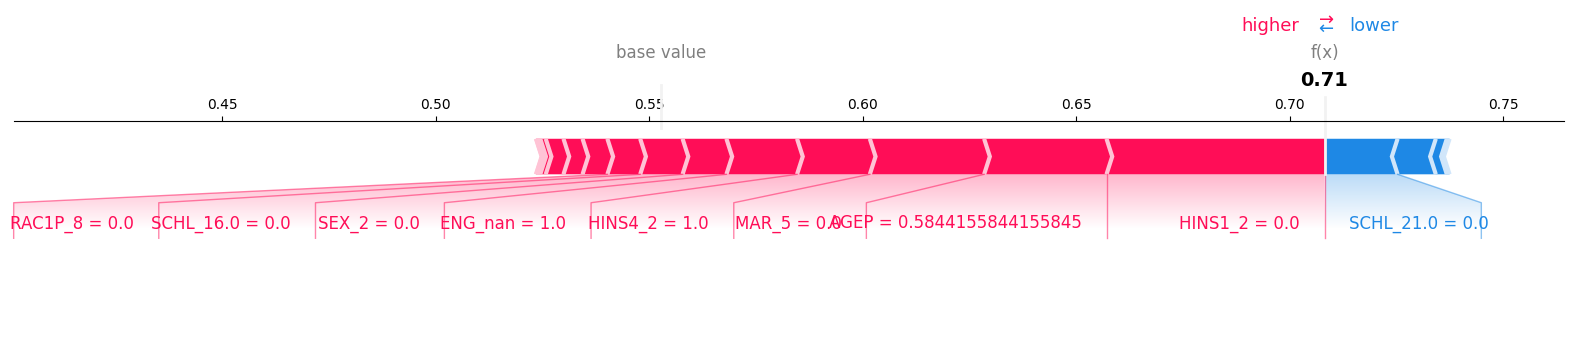

In [26]:
choosen_instance = X_test.loc[[309375]]
shap_values = explainer_rf.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer_rf.expected_value[1], shap_values[1], choosen_instance,  matplotlib=True)

# Task4: Reflection

Task 4
* [ ] Discussion on classifier most suited for the prediction given all considerations?